<a href="https://colab.research.google.com/github/nenadgolubovic/DocumentationManagementSystem/blob/master/Flight_Delay_Predicition_Graph_RGCN_Nodes_Flights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd

In [49]:
df = pd.read_csv(r'/content/drive/MyDrive/1.csv')
df.head()

/tmp/ipython-input-49-919151825.py:1: DtypeWarning: Columns (11,13,87,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'/content/drive/MyDrive/1.csv')


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,MKT_UNIQUE_CARRIER,BRANDED_CODE_SHARE,MKT_CARRIER_AIRLINE_ID,MKT_CARRIER,...,DIV4_WHEELS_OFF,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_AIRPORT_ID,DIV5_AIRPORT_SEQ_ID,DIV5_WHEELS_ON,DIV5_TOTAL_GTIME,DIV5_LONGEST_GTIME,DIV5_WHEELS_OFF,DIV5_TAIL_NUM
0,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
from sklearn.preprocessing import StandardScaler
scaler_y = StandardScaler()
df = df[(df['ARR_DELAY'] > -120) & (df['ARR_DELAY'] < 300)]
df['ARR_DELAY_NORM'] = scaler_y.fit_transform(df[['ARR_DELAY']])

Make sample of 10% to easy manage data for first try


In [51]:
sample = df.sample(frac=0.1, random_state=42)

In [52]:
sample.head()
columns= sample.columns
for i in columns:
  print(i)

YEAR
QUARTER
MONTH
DAY_OF_MONTH
DAY_OF_WEEK
FL_DATE
MKT_UNIQUE_CARRIER
BRANDED_CODE_SHARE
MKT_CARRIER_AIRLINE_ID
MKT_CARRIER
MKT_CARRIER_FL_NUM
SCH_OP_UNIQUE_CARRIER
SCH_OP_CARRIER_AIRLINE_ID
SCH_OP_CARRIER
SCH_OP_CARRIER_FL_NUM
OP_UNIQUE_CARRIER
OP_CARRIER_AIRLINE_ID
OP_CARRIER
TAIL_NUM
OP_CARRIER_FL_NUM
ORIGIN_AIRPORT_ID
ORIGIN_AIRPORT_SEQ_ID
ORIGIN_CITY_MARKET_ID
ORIGIN
ORIGIN_CITY_NAME
ORIGIN_STATE_ABR
ORIGIN_STATE_FIPS
ORIGIN_STATE_NM
ORIGIN_WAC
DEST_AIRPORT_ID
DEST_AIRPORT_SEQ_ID
DEST_CITY_MARKET_ID
DEST
DEST_CITY_NAME
DEST_STATE_ABR
DEST_STATE_FIPS
DEST_STATE_NM
DEST_WAC
CRS_DEP_TIME
DEP_TIME
DEP_DELAY
DEP_DELAY_NEW
DEP_DEL15
DEP_DELAY_GROUP
DEP_TIME_BLK
TAXI_OUT
WHEELS_OFF
WHEELS_ON
TAXI_IN
CRS_ARR_TIME
ARR_TIME
ARR_DELAY
ARR_DELAY_NEW
ARR_DEL15
ARR_DELAY_GROUP
ARR_TIME_BLK
CANCELLED
CANCELLATION_CODE
DIVERTED
DUP
CRS_ELAPSED_TIME
ACTUAL_ELAPSED_TIME
AIR_TIME
FLIGHTS
DISTANCE
DISTANCE_GROUP
CARRIER_DELAY
WEATHER_DELAY
NAS_DELAY
SECURITY_DELAY
LATE_AIRCRAFT_DELAY
FIRST_DEP_TIME


Flights -> NODES

In [54]:
flights = sample.copy()
#flights = flights[flights["DAY_OF_MONTH"]==1]
flights = flights.reset_index(drop=True)
flights["node_id"] = flights.index

nodes_df = flights[["node_id",
                    "YEAR", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK","TAXI_OUT",
                      "WHEELS_OFF","WHEELS_ON", "TAXI_IN", "AIR_TIME","ARR_DELAY_NORM",
                    "OP_UNIQUE_CARRIER", "ORIGIN", "DEST", "OP_CARRIER_FL_NUM",
                    "CRS_DEP_TIME", "DEP_DELAY", "CRS_ARR_TIME", "ARR_DELAY",
                    "DISTANCE", "TAIL_NUM"]].copy()


In [55]:
nodes_df["HOURS_OF_ARRIVAL"] = nodes_df["CRS_ARR_TIME"] // 100
nodes_df["HOURS_OF_DEPARTURES"] = nodes_df["CRS_DEP_TIME"] // 100
nodes_df["MINUTES_OF_ARRIVAL"] = nodes_df["CRS_ARR_TIME"] % 100
nodes_df["MINUTES_OF_DEPARTURES"] = nodes_df["CRS_DEP_TIME"] % 100
nodes_df["MINUTES_TILL_WHEELS_OFF"] = ((nodes_df["WHEELS_OFF"] // 100) * 60 + (nodes_df["WHEELS_OFF"] % 100)) - ((nodes_df["CRS_DEP_TIME"] // 100) * 60 + (nodes_df["CRS_DEP_TIME"] % 100))
nodes_df["MINUTES_WITH_WHEELS_ON"] = ((nodes_df["CRS_ARR_TIME"] // 100) * 60 + (nodes_df["CRS_ARR_TIME"] % 100)) - ((nodes_df["WHEELS_ON"] // 100) * 60 + (nodes_df["WHEELS_ON"] % 100))
# Brisanje originalnih kolona koje više nisu potrebne
nodes_df.drop(columns=["CRS_ARR_TIME", "CRS_DEP_TIME", "WHEELS_OFF", "WHEELS_ON"], inplace=True)

nodes_df.head()


,node_id,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,TAXI_OUT,TAXI_IN,AIR_TIME,ARR_DELAY_NORM,OP_UNIQUE_CARRIER,...,DEP_DELAY,ARR_DELAY,DISTANCE,TAIL_NUM,HOURS_OF_ARRIVAL,HOURS_OF_DEPARTURES,MINUTES_OF_ARRIVAL,MINUTES_OF_DEPARTURES,MINUTES_TILL_WHEELS_OFF,MINUTES_WITH_WHEELS_ON
0,0,2025,1,17,5,12.0,4.0,55.0,-0.312702,WN,...,-5.0,-14.0,324.0,N8829Q,8,7,45,25,7.0,18.0
1,1,2025,1,26,7,21.0,8.0,56.0,-0.174118,AA,...,-2.0,-6.0,370.0,N829NN,15,13,33,4,19.0,14.0
2,2,2025,1,25,6,24.0,7.0,173.0,-0.122149,YX,...,-5.0,-3.0,1217.0,N124HQ,11,7,7,45,19.0,10.0
3,3,2025,1,4,6,18.0,7.0,149.0,-0.693809,G4,...,-20.0,-36.0,1220.0,198NV,11,8,11,1,-2.0,43.0
4,4,2025,1,14,2,30.0,13.0,39.0,0.258958,OO,...,27.0,19.0,157.0,N937EV,8,7,1,31,57.0,-6.0


In [56]:
len(nodes_df)

59901

In [57]:
nodes_df = nodes_df.dropna(subset=['ARR_DELAY_NORM'])
nodes_df

,node_id,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,TAXI_OUT,TAXI_IN,AIR_TIME,ARR_DELAY_NORM,OP_UNIQUE_CARRIER,...,DEP_DELAY,ARR_DELAY,DISTANCE,TAIL_NUM,HOURS_OF_ARRIVAL,HOURS_OF_DEPARTURES,MINUTES_OF_ARRIVAL,MINUTES_OF_DEPARTURES,MINUTES_TILL_WHEELS_OFF,MINUTES_WITH_WHEELS_ON
0,0,2025,1,17,5,12.0,4.0,55.0,-0.312702,WN,...,-5.0,-14.0,324.0,N8829Q,8,7,45,25,7.0,18.0
1,1,2025,1,26,7,21.0,8.0,56.0,-0.174118,AA,...,-2.0,-6.0,370.0,N829NN,15,13,33,4,19.0,14.0
2,2,2025,1,25,6,24.0,7.0,173.0,-0.122149,YX,...,-5.0,-3.0,1217.0,N124HQ,11,7,7,45,19.0,10.0
3,3,2025,1,4,6,18.0,7.0,149.0,-0.693809,G4,...,-20.0,-36.0,1220.0,198NV,11,8,11,1,-2.0,43.0
4,4,2025,1,14,2,30.0,13.0,39.0,0.258958,OO,...,27.0,19.0,157.0,N937EV,8,7,1,31,57.0,-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59896,59896,2025,1,4,6,11.0,5.0,107.0,0.882587,WN,...,57.0,55.0,701.0,N8919K,22,19,25,20,68.0,-50.0
59897,59897,2025,1,20,1,9.0,4.0,76.0,-0.295379,DL,...,-2.0,-13.0,515.0,N956DZ,14,12,9,29,7.0,17.0
59898,59898,2025,1,3,5,18.0,4.0,108.0,-0.208764,AA,...,-8.0,-8.0,700.0,N708UW,17,15,50,40,10.0,12.0
59899,59899,2025,1,24,5,15.0,9.0,61.0,-0.676486,DL,...,-11.0,-35.0,436.0,N321DU,7,5,24,35,4.0,44.0


In [58]:
nodes_df_one_day = nodes_df[nodes_df["DAY_OF_MONTH"] == 17]
nodes_df_one_day_test = nodes_df[nodes_df["DAY_OF_MONTH"] == 25]
nodes_df_one_week = nodes_df[(nodes_df["DAY_OF_MONTH"] >= 15) & (nodes_df["DAY_OF_MONTH"] <= 22)]


In [59]:
import torch
from torch.utils.data import DataLoader, Dataset

class FlightDataset(Dataset):
  def __init__(self,df):
    self.df = df
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    return torch.tensor(row.values, dtype = torch.float32)


In [60]:
from collections import defaultdict
def create_edges_by_airport_time(df, max_time_diff=10):
    edges = []
    df = df.copy()

    # Dodavanje vremena u minutima
    df['DEP_TIME_MIN'] = df['HOURS_OF_DEPARTURES'] * 60 + df['MINUTES_OF_DEPARTURES']
    df['ARR_TIME_MIN'] = df['HOURS_OF_ARRIVAL'] * 60 + df['MINUTES_OF_ARRIVAL']

    # Grupisanje po aerodromima (ORIGIN i DEST)
    airport_to_indices = defaultdict(list)

    for idx, row in df.iterrows():
        airport_to_indices[row['ORIGIN']].append(('DEP', idx, row['DEP_TIME_MIN']))
        airport_to_indices[row['DEST']].append(('ARR', idx, row['ARR_TIME_MIN']))

    for airport, events in airport_to_indices.items():
        events.sort(key=lambda x: x[2])  # sortiraj po vremenu

        for i in range(len(events)):
            _, idx_i, time_i = events[i]
            for j in range(i + 1, len(events)):
                _, idx_j, time_j = events[j]
                if time_j - time_i > max_time_diff:
                    break
                edges.append((idx_i, idx_j))
                edges.append((idx_j, idx_i))  # simetrična veza

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

In [61]:
def create_edges_by_tail_number(df):
    edges = []
    tail_to_indices = defaultdict(list)

    for idx, tail in enumerate(df['TAIL_NUM']):
        tail_to_indices[tail].append(idx)

    for indices in tail_to_indices.values():
        if len(indices) > 1:
            for i in range(len(indices)):
                for j in range(i + 1, len(indices)):
                    src, dst = indices[i], indices[j]
                    edges.append((src, dst))
                    edges.append((dst, src))  # obostrana veza

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

In [62]:
def create_edges_by_flight_number(df):
    edges = []
    flight_to_indices = defaultdict(list)

    for idx, flight in enumerate(df['OP_CARRIER_FL_NUM']):
        flight_to_indices[flight].append(idx)

    for indices in flight_to_indices.values():
        if len(indices) > 1:
            for i in range(len(indices)):
                for j in range(i + 1, len(indices)):
                    src, dst = indices[i], indices[j]
                    edges.append((src, dst))
                    edges.append((dst, src))  # obostrano

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

In [63]:
def create_edges_same_carrier(df):
    carrier_to_indices = defaultdict(list)

    for idx, carrier in enumerate(df['OP_UNIQUE_CARRIER']):
        carrier_to_indices[carrier].append(idx)

    edges = []
    for indices in carrier_to_indices.values():
        if len(indices) < 2:
            continue
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                edges.append((indices[i], indices[j]))
                edges.append((indices[j], indices[i]))
    if len(edges) == 0:
        return torch.empty((2,0), dtype=torch.long)
    return torch.tensor(edges, dtype=torch.long).t().contiguous()  # dim: [2, E]

In [ ]:
!pip install torch_geometric

In [64]:
import torch
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from torch_geometric.nn import RGCNConv
import torch.nn.functional as F

# --- Pretvaranje node feature u tensor ---
# Ovde biramo numeričke kolone koje ćemo koristiti kao ulazne feature
# Primer: koristi sve osim ID, labela i string kolona (možeš dodati i one koje kodiraš)
# Kodiranje kategorijskih kolona
# Primer: tvoj očišćen DataFrame
df_clean = nodes_df.fillna(0)

In [76]:

# 🔹 Kodiraj kategorijske kolone za sve podatke pre grupisanja
le_origin = LabelEncoder()
le_dest = LabelEncoder()

df_clean['ORIGIN_ENC'] = le_origin.fit_transform(df_clean['ORIGIN'].astype(str))
df_clean['DEST_ENC'] = le_dest.fit_transform(df_clean['DEST'].astype(str))

# 🔹 Kolone koje koristiš kao feature
le_origin = LabelEncoder()
le_dest = LabelEncoder()
le_op_carrier = LabelEncoder()

le_origin.fit(nodes_df['ORIGIN'].astype(str))
le_dest.fit(nodes_df['DEST'].astype(str))
le_op_carrier.fit(nodes_df['OP_UNIQUE_CARRIER'].astype(str))

num_features_cols = ['YEAR',
                     'MONTH',
                     'DAY_OF_MONTH',
                     'DAY_OF_WEEK',
                      #'TAXI_OUT',
                      #'TAXI_IN',
                      #'AIR_TIME',
                     'ORIGIN_ENC',
                     'DEST_ENC',
                     'DISTANCE',
                     'HOURS_OF_ARRIVAL',
                     'HOURS_OF_DEPARTURES',
                     'MINUTES_OF_ARRIVAL',
                     'MINUTES_OF_DEPARTURES',
                     'OP_UNIQUE_CARRIER',
                     #'MINUTES_TILL_WHEELS_OFF',
                     #'MINUTES_WITH_WHEELS_ON'
                     ]

day_of_week_dummies = pd.get_dummies(nodes_df['DAY_OF_WEEK'], prefix='DAY_OF_WEEK')
num_features_cols += list(day_of_week_dummies.columns)

def create_graph_data_from_day(df_day):
    df_day = df_day.reset_index(drop=True).copy()
    # --- LabelEncoderi (moraju biti trenirani na celom skupu!) ---
    df_day['ORIGIN_ENC'] = le_origin.transform(df_day['ORIGIN'].astype(str))
    df_day['DEST_ENC'] = le_dest.transform(df_day['DEST'].astype(str))
    df_day['OP_UNIQUE_CARRIER'] = le_op_carrier.transform(df_day['OP_UNIQUE_CARRIER'].astype(str))


    # --- Feature tensor ---
    x = torch.tensor(df_day[num_features_cols].values, dtype=torch.float)

    # --- Label (npr. ARR_DELAY, za klasifikaciju možeš pretvoriti u klase) ---
    y = torch.tensor(df_day['ARR_DELAY_NORM'].values, dtype=torch.float).unsqueeze(1)

    # --- Edge index i edge_type ---
    edge_index_0 = create_edges_by_tail_number(df_day)
    edge_index_1 = create_edges_by_flight_number(df_day)
    edge_index_2 = create_edges_by_airport_time(df_day, 10)
    edge_index_3 = create_edges_same_carrier(df_day)

    edge_index = torch.cat([edge_index_0, edge_index_1, edge_index_2], dim=1)
    edge_type = torch.tensor(
        [0] * edge_index_0.size(1) +
        [1] * edge_index_1.size(1) +
        [2] * edge_index_2.size(1),
        dtype=torch.long
    )

    return Data(x=x, edge_index=edge_index, edge_type=edge_type, y=y)

In [77]:
import pandas as pd
nodes_df = nodes_df.dropna(subset=['YEAR', 'MONTH', 'DAY_OF_MONTH'])
nodes_df['DATE'] = pd.to_datetime(dict(year=nodes_df['YEAR'],
                                      month=nodes_df['MONTH'],
                                      day=nodes_df['DAY_OF_MONTH']))

nodes_df['WEEK'] = nodes_df['DATE'].dt.isocalendar().week
grouped = nodes_df.groupby(['YEAR', 'WEEK', 'DAY_OF_MONTH'])
batches = [group for _, group in grouped]
dataloaders = [DataLoader(FlightDataset(batch), batch_size=len(batch)) for batch in batches]



In [78]:
from torch_geometric.loader import DataLoader as PyGDataLoader

graph_list = []

for i, df_day in enumerate(batches):
    if len(df_day) < 2:
        print(f"[Dan {i}] preskočen jer ima manje od 2 leta")
        continue
    try:
        graph = create_graph_data_from_day(df_day)
        graph_list.append(graph)
        print(f"[Dan {i}] uspešno dodat: {len(df_day)} letova, čvorovi: {graph.num_nodes}, ivica: {graph.edge_index.shape[1]}")
    except Exception as e:
        print(f"[Dan {i}] greška: {e}")

[Dan 0] greška: "['DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7'] not in index"
[Dan 1] greška: "['DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7'] not in index"
[Dan 2] greška: "['DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7'] not in index"
[Dan 3] greška: "['DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7'] not in index"
[Dan 4] greška: "['DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7'] not in index"
[Dan 5] greška: "['DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7'] not in index"
[Dan 6] greška: "['DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

class RGCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations,
                 num_layers=3, dropout=0.5):
        super().__init__()
        assert num_layers >= 2, "Broj slojeva mora biti najmanje 2"

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        # Prvi sloj
        self.convs.append(RGCNConv(in_channels, hidden_channels, num_relations=num_relations))
        self.bns.append(nn.BatchNorm1d(hidden_channels))

        # Srednji slojevi
        for _ in range(num_layers - 2):
            self.convs.append(RGCNConv(hidden_channels, hidden_channels, num_relations=num_relations))
            self.bns.append(nn.BatchNorm1d(hidden_channels))

        # Poslednji sloj
        self.convs.append(RGCNConv(hidden_channels, out_channels, num_relations=num_relations))

        self.dropout = dropout

    def forward(self, x, edge_index, edge_type):
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index, edge_type)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index, edge_type)
        return x


In [69]:
graph_list[0]

Data(x=[1798, 12], edge_index=[2, 6506], y=[1798, 1], edge_type=[6506])

In [70]:
from torch_geometric.loader import DataLoader as PyGDataLoader
import torch
import torch.nn as nn

# 🔹 Pretpostavimo da je graph_list lista od 30 grafova (po jedan za svaki dan)
dataloader = PyGDataLoader(graph_list, batch_size=1, shuffle=True)

model = RGCNModel(
    in_channels=graph_list[0].x.shape[1],
    hidden_channels=64,
    out_channels=1,
    num_relations=3,
    num_layers=3,
    dropout=0.5
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

num_epochs = 1000  # ili više, po potrebi

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0

    for i, batch in enumerate(dataloader):
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_type)

        # Provera na NaN/Inf
        if torch.isnan(out).any() or torch.isinf(out).any():
            print(f"[Epoch {epoch}] NaN/Inf u izlazu modela! Preskačem batch {i}")
            continue
        if torch.isnan(batch.y).any() or torch.isinf(batch.y).any():
            print(f"[Epoch {epoch}] NaN/Inf u targetu! Preskačem batch {i}")
            continue

        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"[Epoch {epoch}] Average Loss: {avg_loss:.4f}")

print("✅ Trening završen.")


[Epoch 1] Average Loss: 2.1461
[Epoch 2] Average Loss: 1.1279
[Epoch 3] Average Loss: 1.0666
[Epoch 4] Average Loss: 1.0496
[Epoch 5] Average Loss: 1.0354
[Epoch 6] Average Loss: 1.0309
[Epoch 7] Average Loss: 1.0283
[Epoch 8] Average Loss: 1.0413
[Epoch 9] Average Loss: 1.0364
[Epoch 10] Average Loss: 1.0361
[Epoch 11] Average Loss: 1.0220
[Epoch 12] Average Loss: 1.0256
[Epoch 13] Average Loss: 1.0247
[Epoch 14] Average Loss: 1.0220
[Epoch 15] Average Loss: 1.0194
[Epoch 16] Average Loss: 1.0174
[Epoch 17] Average Loss: 1.0197
[Epoch 18] Average Loss: 1.0221
[Epoch 19] Average Loss: 1.0181
[Epoch 20] Average Loss: 1.0247
[Epoch 21] Average Loss: 1.0202
[Epoch 22] Average Loss: 1.0184
[Epoch 23] Average Loss: 1.0237
[Epoch 24] Average Loss: 1.0217
[Epoch 25] Average Loss: 1.0175
[Epoch 26] Average Loss: 1.0173
[Epoch 27] Average Loss: 1.0174
[Epoch 28] Average Loss: 1.0174
[Epoch 29] Average Loss: 1.0198
[Epoch 30] Average Loss: 1.0166
[Epoch 31] Average Loss: 1.0189
[Epoch 32] Averag

In [71]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

model.eval()
all_preds = []
all_targets = []
dataloader = PyGDataLoader(graph_list, batch_size=1, shuffle=True)
with torch.no_grad():
    for batch in dataloader:
        out = model(batch.x, batch.edge_index, batch.edge_type)
        preds = out.squeeze().cpu().numpy()
        targets = batch.y.squeeze().cpu().numpy()

        all_preds.extend(preds)
        all_targets.extend(targets)

# Izračunaj metrike
mse = mean_squared_error(all_targets, all_preds)
mae = mean_absolute_error(all_targets, all_preds)

# Izračun prosečnog kašnjenja u minutima (apsolutna greška)
avg_delay = np.mean(np.abs(np.array(all_preds) - np.array(all_targets)))

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Prosečno kašnjenje u minutima: {avg_delay:.2f}")

Test MSE: 0.8906
Test MAE: 0.4459
Prosečno kašnjenje u minutima: 0.45


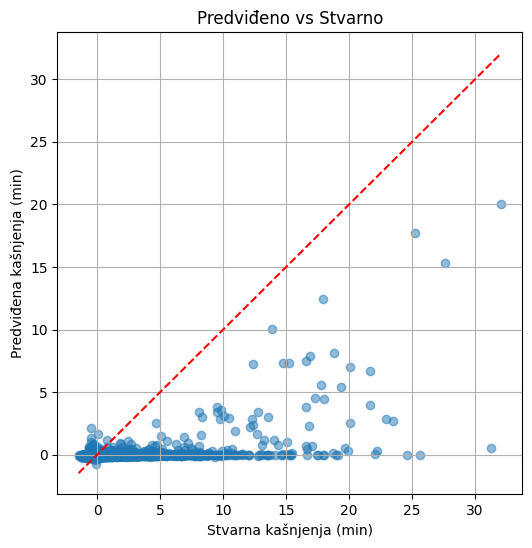

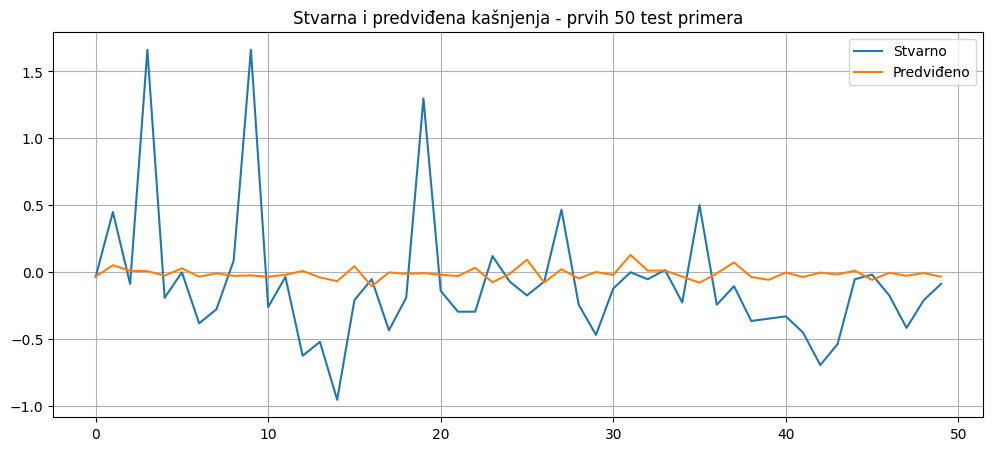

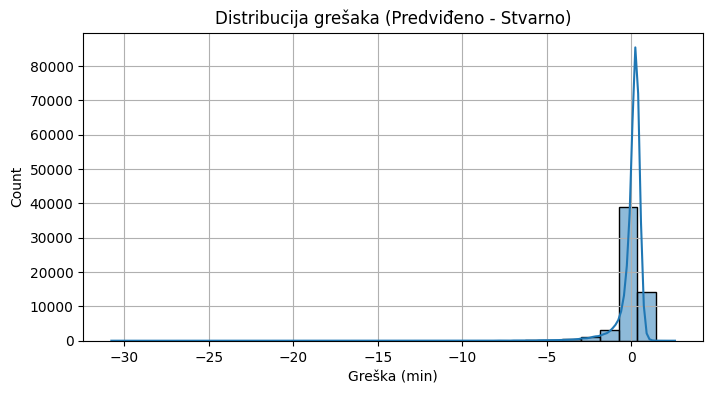

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# all_targets i all_preds su numpy nizovi dobijeni u test delu:
# all_targets = [...]
# all_preds = [...]

# 1. Scatter plot: stvarno vs predviđeno
plt.figure(figsize=(6,6))
plt.scatter(all_targets, all_preds, alpha=0.5)
plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r--')  # y=x linija
plt.xlabel("Stvarna kašnjenja (min)")
plt.ylabel("Predviđena kašnjenja (min)")
plt.title("Predviđeno vs Stvarno")
plt.grid(True)
plt.show()

# 2. Line plot prvih 50 primera
plt.figure(figsize=(12,5))
plt.plot(all_targets[:50], label='Stvarno')
plt.plot(all_preds[:50], label='Predviđeno')
plt.legend()
plt.title("Stvarna i predviđena kašnjenja - prvih 50 test primera")
plt.grid(True)
plt.show()

# 3. Histogram grešaka (rezidual)
errors = np.array(all_preds) - np.array(all_targets)
plt.figure(figsize=(8,4))
sns.histplot(errors, bins=30, kde=True)
plt.title("Distribucija grešaka (Predviđeno - Stvarno)")
plt.xlabel("Greška (min)")
plt.grid(True)
plt.show()

CLASSIFICATION

In [ ]:
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

# Pretpostavka: le_origin, le_dest, le_op_carrier su već fitovani na celom skupu (kao što si ti već uradio)

# Izmena: napravi novu enkodiranu kolonu za OP_UNIQUE_CARRIER, ne menjaj original
def create_graph_data_from_day(df_day):
    df_day = df_day.reset_index(drop=True).copy()

    # Kodiraj kategorijske kolone
    df_day['ORIGIN_ENC'] = le_origin.transform(df_day['ORIGIN'].astype(str))
    df_day['DEST_ENC'] = le_dest.transform(df_day['DEST'].astype(str))
    df_day['OP_UNIQUE_CARRIER_ENC'] = le_op_carrier.transform(df_day['OP_UNIQUE_CARRIER'].astype(str))

    # Pretvori ARR_DELAY u klase (primer binarne klasifikacije)
    # 0 = bez ili malo kašnjenje (<=15 min), 1 = kašnjenje > 15 min
    df_day['ARR_DELAY_CLASS'] = (df_day['ARR_DELAY'] > 0).astype(int)

    # Kolone koje se koriste kao feature, zameni OP_UNIQUE_CARRIER string sa OP_UNIQUE_CARRIER_ENC
    num_features_cols = ['YEAR',
                         'MONTH',
                         'DAY_OF_MONTH',
                         'DAY_OF_WEEK',
                         #'TAXI_OUT',
                         #'TAXI_IN',
                         #'AIR_TIME',
                         'ORIGIN_ENC',
                         'DEST_ENC',
                         'DISTANCE',
                         'HOURS_OF_ARRIVAL',
                         'HOURS_OF_DEPARTURES',
                         'MINUTES_OF_ARRIVAL',
                         'MINUTES_OF_DEPARTURES',
                         'OP_UNIQUE_CARRIER_ENC'
                         #'MINUTES_TILL_WHEELS_OFF',
                         #'MINUTES_WITH_WHEELS_ON'
                        ]

    # --- Feature tensor ---
    x = torch.tensor(df_day[num_features_cols].values, dtype=torch.float)

    # --- Label tensor ---
    y = torch.tensor(df_day['ARR_DELAY_CLASS'].values, dtype=torch.long)  # 1D LongTensor za klasifikaciju

    # --- Edge index i edge_type ---
    edge_index_0 = create_edges_by_tail_number(df_day)
    edge_index_1 = create_edges_by_flight_number(df_day)
    edge_index_2 = create_edges_by_airport_time(df_day, 10)
    # Iz tvog primera ti edge_index_3 se ne koristi, ako želiš možeš ga dodati

    edge_index = torch.cat([edge_index_0, edge_index_1, edge_index_2], dim=1)
    edge_type = torch.tensor(
        [0] * edge_index_0.size(1) +
        [1] * edge_index_1.size(1) +
        [2] * edge_index_2.size(1),
        dtype=torch.long
    )

    return Data(x=x, edge_index=edge_index, edge_type=edge_type, y=y)


In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import RGCNConv
import torch.nn.functional as F

class RGCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations=num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations=num_relations)

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        # Za višeklasnu klasifikaciju CrossEntropyLoss očekuje raw logits, pa ne stavljamo softmax ovde
        return x

In [ ]:
from torch_geometric.loader import DataLoader as PyGDataLoader

# Pretpostavka: graph_list je lista PyG Data objekata, svaki ima y sa klasama kao integer labelama
dataloader = PyGDataLoader(graph_list, batch_size=1, shuffle=True)

model = RGCNModel(
    in_channels=graph_list[0].x.shape[1],
    hidden_channels=128,
    out_channels=2,   # broj klasa
    num_relations=3
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()  # Za klasifikaciju

num_epochs_per_batch = 1000

for i, batch in enumerate(dataloader):
    print(f"--- Trening na batch-u {i} ---")
    for epoch in range(1, num_epochs_per_batch + 1):
        model.train()
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index, batch.edge_type)  # shape [num_nodes, 2]

        if torch.isnan(out).any() or torch.isinf(out).any():
            print("NaN ili Inf u izlazu modela!")
            break

        if torch.isnan(batch.y).any() or torch.isinf(batch.y).any():
            print("NaN ili Inf u targetu!")
            break

        # CrossEntropyLoss očekuje da y bude LongTensor sa labelama
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Batch {i}, Epoch {epoch}, Loss: {loss.item():.4f}")

    print(f"Završeno treniranje batch-a {i}")

print("Trening završen za sve batch-eve.")

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.edge_type)  # logits [num_nodes, num_classes]

            # Predikcija je klasa sa max logit vrednošću
            preds = out.argmax(dim=1).cpu()
            labels = batch.y.cpu()

            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return all_preds, all_labels

# Na primer, ako je tvoj test_loader ovako napravljen:
# test_loader = PyGDataLoader(test_graph_list, batch_size=1, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

preds, labels = evaluate_model(model, dataloader, device)

# Izračunaj matricu konfuzije
cm = confusion_matrix(labels, preds)
print("Matrica konfuzije:\n", cm)

# Opcionalno: lepši prikaz matrice konfuzije
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predviđene klase')
plt.ylabel('Stvarne klase')
plt.title('Matrica konfuzije')
plt.show()

# Opcionalno: detaljni izveštaj o klasifikaciji
print(classification_report(labels, preds))


In [ ]:
flights_test = sample_test.copy()
flights_test = flights_test.reset_index(drop=True)
flights_test["node_id"] = flights_test.index

nodes_df_test = flights_test[["node_id","YEAR", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK","TAXI_OUT",
                      "WHEELS_OFF","WHEELS_ON", "TAXI_IN", "AIR_TIME",
                    "OP_UNIQUE_CARRIER", "ORIGIN", "DEST",
                    "CRS_DEP_TIME", "DEP_DELAY", "CRS_ARR_TIME", "ARR_DELAY",
                    "DISTANCE", "TAIL_NUM"]].copy()
nodes_df_test.head()

In [ ]:
nodes_df_test["HOURS_OF_ARRIVAL"] = nodes_df_test["CRS_ARR_TIME"] // 100
nodes_df_test["HOURS_OF_DEPARTURES"] = nodes_df_test["CRS_DEP_TIME"] // 100
nodes_df_test["MINUTES_OF_ARRIVAL"] = nodes_df_test["CRS_ARR_TIME"] % 100
nodes_df_test["MINUTES_OF_DEPARTURES"] = nodes_df_test["CRS_DEP_TIME"] % 100
nodes_df_test["MINUTES_TILL_WHEELS_OFF"] = ((nodes_df_test["WHEELS_OFF"] // 100) * 60 + (nodes_df_test["WHEELS_OFF"] % 100)) - ((nodes_df_test["CRS_DEP_TIME"] // 100) * 60 + (nodes_df_test["CRS_DEP_TIME"] % 100))
nodes_df_test["MINUTES_WITH_WHEELS_ON"] = ((nodes_df_test["CRS_ARR_TIME"] // 100) * 60 + (nodes_df_test["CRS_ARR_TIME"] % 100)) - ((nodes_df_test["WHEELS_ON"] // 100) * 60 + (nodes_df_test["WHEELS_ON"] % 100))
# Brisanje originalnih kolona koje više nisu potrebne
nodes_df_test.drop(columns=["CRS_ARR_TIME", "CRS_DEP_TIME", "WHEELS_OFF", "WHEELS_ON"], inplace=True)

nodes_df_test.head()


In [ ]:
sample_test = pd.read_csv(r'sample_2.csv')

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import RGCNConv
import torch.nn.functional as F

# --- Pretvaranje node feature u tensor ---
# Ovde biramo numeričke kolone koje ćemo koristiti kao ulazne feature
# Primer: koristi sve osim ID, labela i string kolona (možeš dodati i one koje kodiraš)

num_features_cols = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
                     'TAXI_OUT', 'TAXI_IN', 'AIR_TIME', 'DISTANCE',
                     'HOURS_OF_ARRIVAL', 'HOURS_OF_DEPARTURES',
                     'MINUTES_OF_ARRIVAL', 'MINUTES_OF_DEPARTURES',
                     'MINUTES_TILL_WHEELS_OFF', 'MINUTES_WITH_WHEELS_ON']
df_clean_test = nodes_df_test.fillna(0)
# Pretvori u torch tensor
x = torch.tensor(df_clean_test[num_features_cols].values, dtype=torch.float)

# Target label, npr. DEP_DELAY
y = torch.tensor(df_clean_test['DEP_DELAY'].values, dtype=torch.float).unsqueeze(1)  # (N,1)

# --- Pretvori edges u tensor ---
# edges je lista (source, target)
edges = create_tailnum_edges(df_clean_test)
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # shape [2, E]

# -- Pošto je RGCN za višestruke tipove relacija treba edge_type --
# Za početak imamo samo jednu vrstu relacije, pa pravimo edge_type nula
edge_type = torch.zeros(edge_index.size(1), dtype=torch.long)

# Kreiraj PyG Data objekat
data_test = Data(x=x, edge_index=edge_index, edge_type=edge_type, y=y)
